<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#ResNet-Model" data-toc-modified-id="ResNet-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ResNet Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from matplotlib.image import imread, imsave
from skimage.color import rgb2lab, lab2rgb
from apex import amp
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [2]:
torch.backends.cudnn.benchmark = True

## Data

In [3]:
def unpack_dataset():
    ! mkdir -p data
    
    # train dataset
    ! wget http://data.csail.mit.edu/places/places365/train_256_places365standard.tar
    ! tar -xvf train_256_places365standard.tar -C data
    
    # validation dataset
    ! wget http://data.csail.mit.edu/places/places365/val_256.tar
    ! tar -xvf val_256.tar -C data
    
    # test dataset
    ! wget http://data.csail.mit.edu/places/places365/test_256.tar
    ! tar -xvf test_256.tar -C data

In [4]:
# unpack_dataset()

In [5]:
# files = glob.glob("data/val_256/*.jpg")
# len(files)

In [6]:
## run it once
## get all color images
# color_files = []
# for f in files:
#     img = imread(f)
#     if img.shape == (256, 256, 3):
#         color_files.append(f)

## save as a file
# with open("data/color_files.txt", "w") as f:
#     f.writelines(f"{f}\n" for f in color_files)

In [7]:
with open("data/color_files.txt") as f:
    color_files = f.read().splitlines()
len(color_files)

36421

In [8]:
color_files[:3]

['data/val_256/Places365_val_00015207.jpg',
 'data/val_256/Places365_val_00000485.jpg',
 'data/val_256/Places365_val_00032508.jpg']

## Dataset

In [9]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        img_lab = rgb2lab(img)
        img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
        img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
        img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        return img_lightness, img_ab
    
    def __len__(self):
        return len(self.files)

In [10]:
train_size = int(len(color_files)*0.8)
train, val = color_files[:train_size], color_files[train_size:]
len(train), len(val)

(29136, 7285)

In [11]:
train_ds = ImageDataset(train)
val_ds = ImageDataset(val)

In [12]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=10)

## ResNet Model

In [13]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [14]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1, keepdim=True))
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.upsample1 = nn.Upsample(scale_factor=4)
        self.upsample2 = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(512, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.features1(x)
        x = self.upsample1(x)
        x = self.features2(x)
        x = self.upsample2(x)
        return self.out_layer(x)

## Training

In [15]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [16]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [17]:
def create_optimizer(model, lr0):
    params = [{"params": model.features1.parameters(), "lr": lr0/9},
              {"params": model.features2.parameters(), "lr": lr0/3},
              {"params": model.upsample1.parameters(), "lr": lr0/9},
              {"params": model.upsample2.parameters(), "lr": lr0/3},
              {"params": model.out_layer.parameters(), "lr": lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [18]:
def train_triangular_policy(model, optimizer, train_dl, val_dl, max_lr=0.01, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr/9, lr/3, lr])
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            idx += 1
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}.pth"
            save_model(model, path)
            print(path)
    return best_val_loss

In [19]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float().cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
    return total_loss/total

In [20]:
model = ColorizationNet().cuda()
optimizer = create_optimizer(model, 0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


max learning rate: 0.01

In [21]:
best_val = train_triangular_policy(model, optimizer, train_dl, val_dl, epochs=10)

train loss: 0.60520757	val loss: 0.05210013
models/model_0.052100.pth
train loss: 0.00746153	val loss: 0.00241497
models/model_0.002415.pth
train loss: 0.00248591	val loss: 0.00249032
train loss: 0.00254390	val loss: 0.00251094
train loss: 0.00257184	val loss: 0.00312614
train loss: 0.00259389	val loss: 0.00260750
train loss: 0.00257068	val loss: 0.00251552
train loss: 0.00251978	val loss: 0.00246186
train loss: 0.00244912	val loss: 0.00235388
models/model_0.002354.pth
train loss: 0.00237472	val loss: 0.00231779
models/model_0.002318.pth


max learning rate: 0.001

In [21]:
best_val = train_triangular_policy(model, optimizer, train_dl, val_dl, max_lr=0.001, epochs=10)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
train loss: 0.69160410	val loss: 0.55104942
models/model_0.551049.pth
train loss: 0.32975042	val loss: 0.13948266
models/model_0.139483.pth
train loss: 0.05235711	val loss: 0.01019467
models/model_0.010195.pth
train loss: 0.00433941	val loss: 0.00253695
models/model_0.002537.pth
train loss: 0.00252670	val loss: 0.00247229
models/model_0.002472.pth
train loss: 0.00250130	val loss: 0.00247416
train loss: 0.00249238	val loss: 0.00246207
models/model_0.002462.pth
train loss: 0.00247659	val loss: 0.00244692
models/model_0.002447.pth
train loss: 0.00245335	val loss: 0.00243202
models/model_0.002432.pth
train loss: 0.00242625	val loss: 0.00242372
models/model_0.002424.pth


## Prediction

In [23]:
def show_prediction(model, image):
    """Given an image, show the grayscale, ground truth and prediction images"""
    img_rgb = imread(image)
    img_lab = rgb2lab(img_rgb)
    img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
    img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
    img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
    
    # grayscale
    img_gray = 255 * img_lightness.squeeze(0)
    
    # prediction
    model.eval()
    x = torch.FloatTensor(img_lightness[None, :, :, :]).cuda()
    y_hat = model(x).cpu().detach().numpy().squeeze(0)
    img_pred = np.concatenate([img_lightness, y_hat], axis=0).transpose(1, 2, 0)
    img_pred = img_pred * [100, 255, 255] - [0, 128, 128]
    img_pred = (255 * lab2rgb(img_pred)).astype("uint8")
    
    # show images
    images = [img_gray, img_rgb, img_pred]
    plt.figure(figsize=(9, 3), dpi=100)
    for idx in range(3):
        plt.subplot(1, 3, idx + 1)
        if idx == 0:
            plt.imshow(images[idx], cmap="gray")
        else:
            plt.imshow(images[idx])
        plt.axis("off")
    plt.show()

max learning rate: 0.01

In [23]:
model = ColorizationNet().cuda()
load_model(model, "models/model_0.002318.pth")

In [24]:
image = "data/val_256/Places365_val_00034662.jpg"

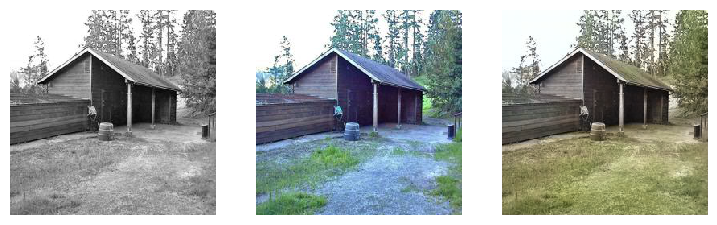

In [25]:
show_prediction(model, image)

max learning rate: 0.001

In [22]:
model = ColorizationNet().cuda()
load_model(model, "models/model_0.002424.pth")

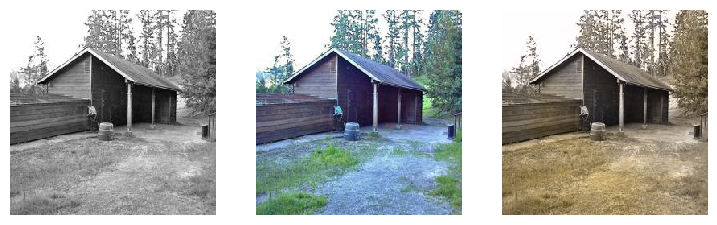

In [25]:
show_prediction(model, image)